In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
import torch.nn.functional as F

In [2]:
# %% Set global parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters and configurations
epochs = 20
batch_size = 8
learning_rate = 1e-3
momentum = 0.9
train_data_ratio = 0.8  # Ratio of training data
save_model = True
model_save_path = '../models/lens_cnn.model'  # Change as needed

# Dataset paths
train_lenses_path = '../dataset/train_lenses/'
train_nonlenses_path = '../dataset/train_nonlenses/'
test_lenses_path = '../dataset/test_lenses/'
test_nonlenses_path = '../dataset/test_nonlenses/'


In [3]:

class LensClassificationDataset(Dataset):
    def __init__(self, lenses_dir, nonlenses_dir, transform=None):
        self.lenses_dir = lenses_dir
        self.nonlenses_dir = nonlenses_dir
        self.transform = transform

        # Get file paths for lensed and non-lensed galaxies
        self.lenses_files = [os.path.join(lenses_dir, f) for f in os.listdir(lenses_dir)]
        self.nonlenses_files = [os.path.join(nonlenses_dir, f) for f in os.listdir(nonlenses_dir)]
        
        # Create a list of all files and corresponding labels
        self.files = self.lenses_files + self.nonlenses_files
        self.labels = [1] * len(self.lenses_files) + [0] * len(self.nonlenses_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        data = np.load(file_path)  # Load the image data
        tensor_data = torch.tensor(data, dtype=torch.float32)

        if self.transform:
            tensor_data = self.transform(tensor_data)

        label = self.labels[idx]
        return tensor_data, label



In [4]:

transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB values between -1 and 1
])
# Create training and testing datasets
train_dataset = LensClassificationDataset(train_lenses_path, train_nonlenses_path, transform)
test_dataset = LensClassificationDataset(test_lenses_path, test_nonlenses_path, transform)

# Print the dataset sizes to make sure they are non-zero
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Split the dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Print sizes after split to ensure no empty dataset
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Number of training samples: 30405
Number of testing samples: 19650
Training size: 24324
Validation size: 6081


In [6]:

class LensCNN(nn.Module):
    def __init__(self):
        super(LensCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 2)  # Output size 2 for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # Flatten for fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output size (batch_size, 2)
        return x



# In[ ]:


# Instantiate model, criterion, and optimizer
model = LensCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model outputs (predictions)
            outputs = model(inputs)
            
            # Convert outputs to probabilities
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of the positive class (lensed)
            all_predictions.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc


In [8]:


def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")



# In[61]:





Epoch [1/10], Loss: 0.1450
Epoch [2/10], Loss: 0.1172
Epoch [3/10], Loss: 0.1057
Epoch [4/10], Loss: 0.0971
Epoch [5/10], Loss: 0.0909
Epoch [6/10], Loss: 0.0830
Epoch [7/10], Loss: 0.0737
Epoch [8/10], Loss: 0.0672
Epoch [9/10], Loss: 0.0631
Epoch [10/10], Loss: 0.0570


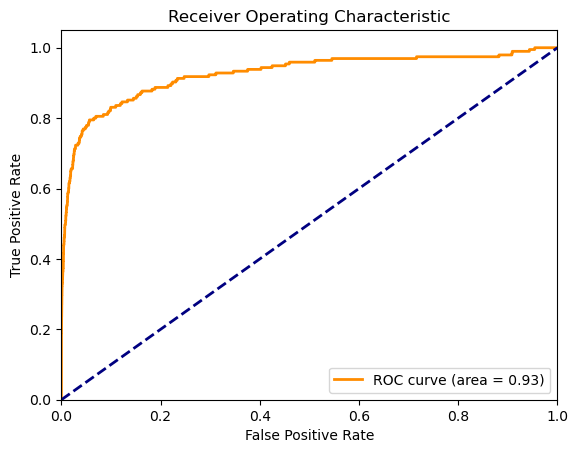

AUC Score: 0.9253460648834589


In [9]:
train_model(model, train_loader, criterion, optimizer, epochs=10)
# Call evaluation after training
roc_auc_score = evaluate_model(model, test_loader)
print(f"AUC Score: {roc_auc_score}")


In [10]:

# %% Evaluate Model on Test Set
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Calculate ROC Curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Test Accuracy: 99.05%


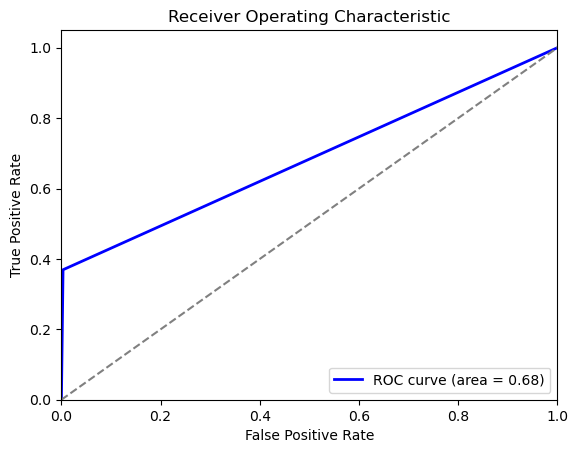

In [11]:

# In[64]:


# Run the evaluation on the test set
test_model(model, test_loader)


# In[ ]: